In [133]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import MDS, TSNE
from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import pairwise_distances
from sklearn.svm import SVC
from sklearn.model_selection import cross_validate
from scipy.cluster.hierarchy import dendrogram, set_link_color_palette
import warnings
from utils import *
warnings.filterwarnings("ignore")

# plot setting
sns.set_context('paper')
sns.set(style = "ticks")
cmap_point = sns.color_palette('muted', as_cmap=True)
# cmap_point = sns.color_palette('muted')
cmap_DB = sns.color_palette('pastel', as_cmap=True)

# random state
np.random.seed(427)
randomseeds = np.random.randint(1992427,size=5)

## Problem 2: Larger unlabeled subset (Written Report)
- Now we will work with the larger, unlabeled subset in p2_unsupervised. This dataset is has not been processed, so you should process using the same log transform as in Problem 1.

### Part 1: Visualization
- Cells in the brain are either excitatory neurons, inhibitory neurons, or non-neuronal cells.
    - 3 main groups
- Within each of these three types, there are numerous distinct sub-types that a cell can be, and sub-types of the same larger class can serve similar functions
    - there are subgroups under main groups

In [2]:
X = np.load('./data/p2_unsupervised/X.npy')
X = np.log2(X+1)

In [3]:
np.trace(X)

1141.7662275009184

#### Part 1.1
Provide at least one visualization which clearly shows the existence of the three main brain cell types described by the scientist, and explain how it shows this. Your visualization should support the idea that cells from a different group (for example, excitatory vs inhibitory) can differ greatly.

##### Part 1.1.1 Find best clustering result with given k-clusters
1. K-means
2. Gaussian Mixture Model
3. given k-clusters Hierarchical clustering
4. Spectral clustering

- Before finding the clustering label, for algorithms using Euclidean distances(etc.) to compute the dissimilarity between samples, we need to do dimensionality reduction to alleviate the "curse of dimensionality".
- Clustering algorithms using Euclidean distances include
    - K-means
    - Hierarchical clustering
    - Spectral clustering
        - performs a low-dimension embedding of the affinity matrix between samples
        - custering alg like MDS

In [4]:
# determine the number of components to use for 
pca = PCA()
X_pca = pca.fit_transform(X)
print(X_pca.shape)

(2169, 2169)


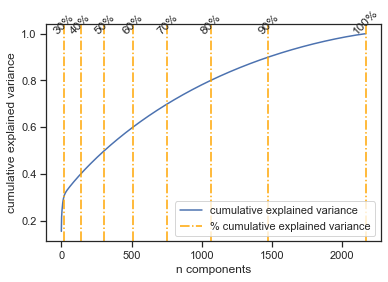

First 509 components have been chosen for further analysis (60% of cumulate explained variance)
Top 2 PC explained 19.92509945219414% of total variance


In [5]:
## at least n% cumulative explained variance ratio
variance_ratio = pca.explained_variance_ratio_
cumulate_ratio = np.cumsum(variance_ratio)
al90 = np.min(np.where(cumulate_ratio>=0.9))
al80 = np.min(np.where(cumulate_ratio>=0.8))
al70 = np.min(np.where(cumulate_ratio>=0.7))
al60 = np.min(np.where(cumulate_ratio>=0.6))
al50 = np.min(np.where(cumulate_ratio>=0.5))
al40 = np.min(np.where(cumulate_ratio>=0.4))
al30 = np.min(np.where(cumulate_ratio>=0.3))
alps = [2169, al90, al80, al70, al60, al50, al40, al30]
## cumulation plot
sns.lineplot(x=range(len(variance_ratio)), y=cumulate_ratio)
for i in range(len(alps)):
    plt.axvline(x=alps[i], color='orange', linestyle='-.')
    plt.text(x=alps[i], y=1, s=f'{100-i*10}%', ha='center', rotation=45)
plt.legend(['cumulative explained variance' ,'% cumulative explained variance'])
plt.ylabel('cumulative explained variance')
plt.xlabel('n components')
plt.savefig('cumulative explained variance.png')
plt.show()
print(f'First {alps[4]} components have been chosen for further analysis (60% of cumulate explained variance)')
print(f'Top 2 PC explained {cumulate_ratio[1]*100}% of total variance')

In [6]:
# project dataset onto first 509 components
pca60p = PCA(n_components = alps[4])
X_pca_60p = pca60p.fit_transform(X)
print(X_pca_60p.shape)

(2169, 509)


In [7]:
# form 2-d MDS plot 0,3
# for rs in randomseeds:
#     mds = MDS(n_components=2, random_state=rs)
#     X_mds = mds.fit_transform(X_pca_60p)
#     f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12.8,4.8))
#     sns.scatterplot(x=X_mds[:,0], y=X_mds[:,1], hue=kmeans_label, ax=ax2, palette=cmap_point[:3])
#     f.suptitle(f'rs={rs}')
#     plt.show()
## mds.stress_ = the loss function of MDS
### (0.5*np.sum((mds.dissimilarity_matrix_ - pairwise_distances(X_mds))**2))
mds = MDS(n_components=2, random_state=randomseeds[3])
X_mds = mds.fit_transform(X_pca_60p)

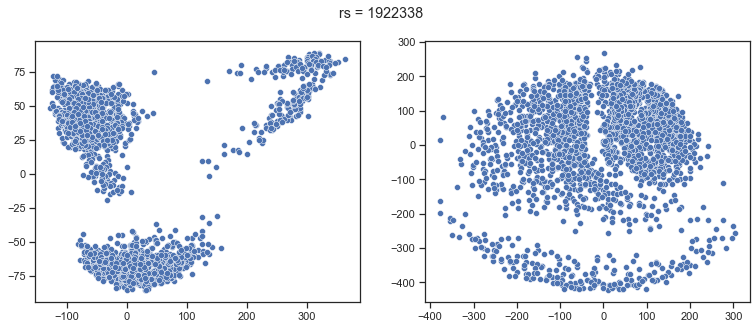

In [8]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12.8,4.8))
sns.scatterplot(x=X_pca_60p[:,0], y=X_pca_60p[:,1], ax=ax1, palette=cmap_point[:3])
sns.scatterplot(x=X_mds[:,0], y=X_mds[:,1], ax=ax2, palette=cmap_point[:3])
f.suptitle(f'rs = {randomseeds[0]}')
plt.show()

In [9]:
# number of main groups
k = 3

rs = 1922338 has been chosen for consistency


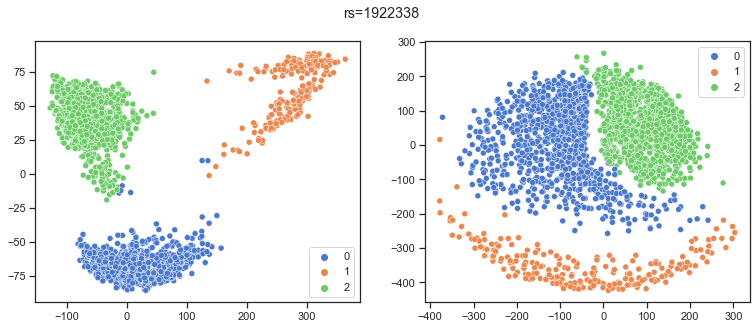

In [134]:
# K-means
# kmeans_labels = []
# for rs in randomseeds:
#     kmeans = KMeans(n_clusters=k, random_state=rs).fit(X_pca_60p)
#     kmeans_label = kmeans.labels_
#     kmeans_labels.append(kmeans_label)
#     f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12.8,4.8))
#     sns.scatterplot(x=X_pca_60p[:,0], y=X_pca_60p[:,1], hue=kmeans_label, ax=ax1, palette=cmap_point[:3])
#     sns.scatterplot(x=X_mds[:,0], y=X_mds[:,1], hue=kmeans_label, ax=ax2, palette=cmap_point[:3])
#     f.suptitle(f'rs={rs}')
#     plt.show()
print(f'rs = {randomseeds[0]} has been chosen for consistency')

kmeans = KMeans(n_clusters=k, random_state=randomseeds[0]).fit(X_pca_60p)
kmeans_label = kmeans.labels_

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12.8,4.8))
sns.scatterplot(x=X_pca_60p[:,0], y=X_pca_60p[:,1], hue=kmeans_label, ax=ax1, palette=cmap_point[:3])
sns.scatterplot(x=X_mds[:,0], y=X_mds[:,1], hue=kmeans_label, ax=ax2, palette=cmap_point[:3])
f.suptitle(f'rs={randomseeds[0]}')
plt.show()

linkage = ward has been chosen for best performance


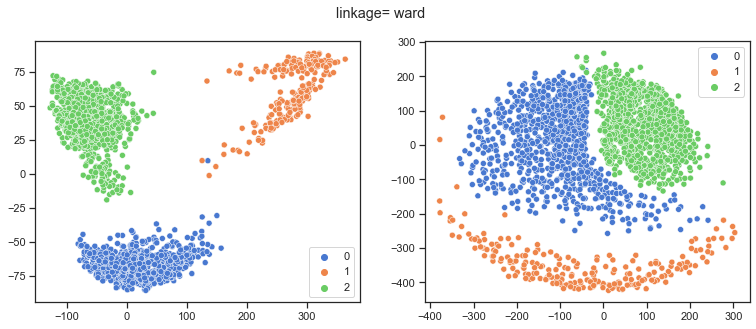

In [135]:
# Hierarchical clustering
linkages = ['ward', 'complete', 'average', 'single']
# HC_labels = []
# for link in linkages:
#     HC = AgglomerativeClustering(n_clusters=k, linkage=link).fit(X_pca_60p)
#     HC_label = HC.labels_
#     HC_labels.append(HC_label)
#     f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12.8,4.8))
#     sns.scatterplot(x=X_pca_60p[:,0], y=X_pca_60p[:,1], hue=HC_label, ax=ax1, palette=cmap_point[:3])
#     sns.scatterplot(x=X_mds[:,0], y=X_mds[:,1], hue=HC_label, ax=ax2, palette=cmap_point[:3])
#     f.suptitle(f'linkage={link}')
#     plt.show()
print(f'linkage = {linkages[0]} has been chosen for best performance')

HC = AgglomerativeClustering(n_clusters=k, linkage=linkages[0], compute_distances=True, compute_full_tree=True).fit(X_pca_60p)
HC_label = HC.labels_


f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12.8,4.8))
sns.scatterplot(x=X_pca_60p[:,0], y=X_pca_60p[:,1], hue=HC_label, ax=ax1, palette=cmap_point[:3])
sns.scatterplot(x=X_mds[:,0], y=X_mds[:,1], hue=HC_label, ax=ax2, palette=cmap_point[:3])
f.suptitle(f'linkage= {linkages[0]}')
plt.show()

covariance_type = full has been chosen for best performance, similar to K-means


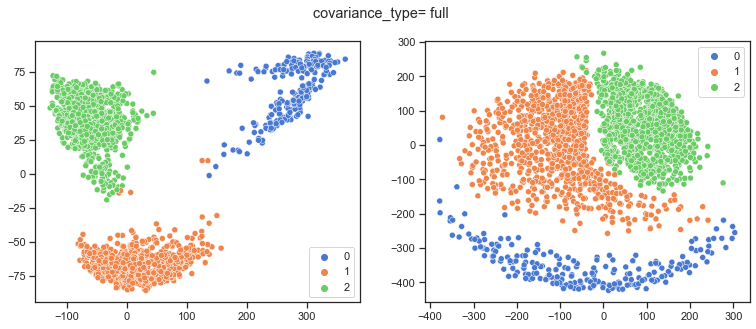

In [136]:
# Gaussian Mixture Model

cov_types = ['spherical', 'tied', 'diag', 'full']
# GMM_labels = []
# for cov_type in cov_types:
#     GMM = GaussianMixture(n_components=k, covariance_type=cov_type).fit(X_pca_60p)
#     GMM_label = GMM.predict(X_pca_60p)
#     GMM_labels.append(GMM_label)
#     f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12.8,4.8))
#     sns.scatterplot(x=X_pca_60p[:,0], y=X_pca_60p[:,1], hue=GMM_label, ax=ax1, palette=cmap_point[:3])
#     sns.scatterplot(x=X_mds[:,0], y=X_mds[:,1], hue=GMM_label, ax=ax2, palette=cmap_point[:3])
#     f.suptitle(f'covariance_type={cov_type}')
#     plt.show()
print(f'covariance_type = {cov_types[-1]} has been chosen for best performance, similar to K-means')


GMM = GaussianMixture(n_components=k, covariance_type=cov_types[-1]).fit(X_pca_60p)
GMM_label = GMM.predict(X_pca_60p)


f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12.8,4.8))
sns.scatterplot(x=X_pca_60p[:,0], y=X_pca_60p[:,1], hue=GMM_label, ax=ax1, palette=cmap_point[:3])
sns.scatterplot(x=X_mds[:,0], y=X_mds[:,1], hue=GMM_label, ax=ax2, palette=cmap_point[:3])
f.suptitle(f'covariance_type= {cov_types[-1]}')
plt.show()

In [137]:
# Spectral clustering
affinities = ['nearest_neighbors', 'rbf']
affinities_precomputed = ['precomputed', 'precomputed_nearest_neighbors']
SC_labels = []
# for aff in affinities:
#     SC = SpectralClustering(n_clusters=k, random_state=randomseeds[0], affinity=aff).fit(X_pca_60p)
#     SC_label = SC.labels_
#     SC_labels.append(SC_label)
    
#     f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12.8,4.8))
#     sns.scatterplot(x=X_pca_60p[:,0], y=X_pca_60p[:,1], hue=SC_label, ax=ax1, palette=cmap_point[:3])
#     sns.scatterplot(x=X_mds[:,0], y=X_mds[:,1], hue=SC_label, ax=ax2, palette=cmap_point[:3])
#     f.suptitle(f'affinity={aff}')
#     plt.show()


# for affpre in affinities_precomputed:
#     SC = SpectralClustering(n_clusters=k, random_state=randomseeds[0], affinity=aff).fit(pairwise_distances(X_pca_60p))
#     SC_label = SC.labels_
#     SC_labels.append(SC_label)
    
#     f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12.8,4.8))
#     sns.scatterplot(x=X_pca_60p[:,0], y=X_pca_60p[:,1], hue=SC_label, ax=ax1, palette=cmap_point[:3])
#     sns.scatterplot(x=X_mds[:,0], y=X_mds[:,1], hue=SC_label, ax=ax2, palette=cmap_point[:3])
#     f.suptitle(f'affinity={affpre}')
#     plt.show()   
print(f'Spectral clustering is not suitable')

Spectral clustering is not suitable


In [234]:
# get unified pseudo label
def unify_pseudo_label(pseudo_label):
    label_count=[]
    _y = pseudo_label.copy()
    for unique in np.unique(pseudo_label):
        label_count.append(np.count_nonzero(pseudo_label == unique))

    sort_count = np.argsort(label_count)
    for i in range(len(sort_count)):
        _y[pseudo_label==sort_count[i]] = i
    return _y

In [235]:
unify_pseudo_label(HC_label)

array([1, 1, 1, ..., 0, 0, 0])

##### Part 1.1.2 Add Decision boundaries on 2-d plot

In [236]:
X_pca2 = X_pca_60p[:,:2]
y= count_sort_pseudo_label(HC_label)

# PCA2 boundaries
clf = SVC(random_state=0, C=0.4, break_ties=True, probability=True)
cv_results = cross_validate(clf, X_pca2, y, return_estimator=True)
print('cv test score = ', cv_results['test_score'])

clf_3class_pca2 = cv_results['estimator'][np.argmax(cv_results['test_score'])]
print('train acc =\n', clf_3class_pca2.score(X_pca2, y))
print('---')
# np.where(clf_3class_pca2.predict(X_pca2)!=y), clf_3class_pca2.get_params()

cv test score =  [0.99078341 1.         1.         1.         0.99769053]
train acc =
 0.9995389580451821
---


In [237]:
# mds boundaries 0,1.4。3,11

clf = SVC(random_state=0, C=10.6, break_ties=True, probability=True)
cv_results = cross_validate(clf, X_mds, y, return_estimator=True)
print('cv test score = ', cv_results['test_score'])

clf_3class_mds = cv_results['estimator'][np.argmax(cv_results['test_score'])]
print('train acc =\n', clf_3class_mds.score(X_mds, y))
print('---')
# np.where(clf_3class_mds.predict(X_mds)!=y), clf_3class_mds.get_params()

cv test score =  [0.99308756 0.99769585 1.         0.99769585 0.98614319]
train acc =
 0.9995389580451821
---


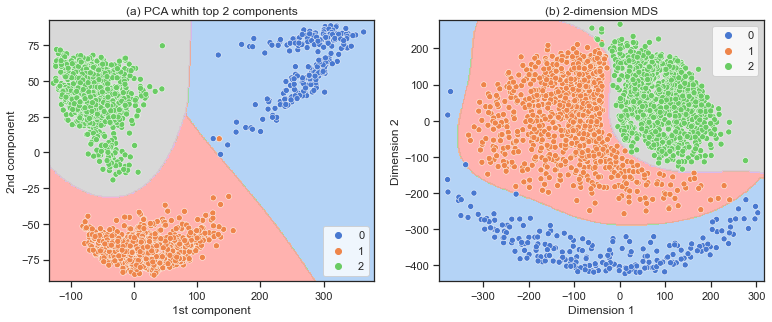

In [238]:
# output fig
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12.8,4.8))


# plot PCA
ax1.set_title('(a) PCA whith top 2 components')
x1x1_pca2, x2x2_pca2 = make_meshgrid(X_pca2[:,0], X_pca2[:,1])
plot_contours(ax1, clf_3class_pca2, x1x1_pca2, x2x2_pca2, colors=cmap_DB, alpha=0.8)
sns.scatterplot(x=X_pca2[:,0], y=X_pca2[:,1], hue=y, ax=ax1, palette=cmap_point[:3])
ax1.set_xlabel('1st component')
ax1.set_ylabel('2nd component')

# plot MDS
ax2.set_title('(b) 2-dimension MDS')
x1x1_mds, x2x2_mds = make_meshgrid(X_mds[:,0], X_mds[:,1])
plot_contours(ax2, clf_3class_mds, x1x1_mds, x2x2_mds, colors=cmap_DB, alpha=0.8)
sns.scatterplot(x=X_mds[:,0], y=X_mds[:,1], hue=y, ax=ax2, palette=cmap_point[:3])
ax2.set_xlabel('Dimension 1')
ax2.set_ylabel('Dimension 2')
# export fig
f.savefig('p2-part1-1.png') 
plt.show()

In [141]:
(1/0.4)/(1/10.6)

26.499999999999996

#### Part 1.2
Provide at least one visualization which supports the claim that within each of the three types, there are numerous possible sub-types for a cell. In your visualization, highlight which of the three main types these sub-types belong to. Again, explain how your visualization supports the claim.

In [250]:
def plot_dendrogram(model, cmap=None, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)
    # set_link_color_palette
    set_link_color_palette(cmap)
    # Plot the corresponding dendrogram
    return dendrogram(linkage_matrix, **kwargs)

In [251]:
np.sum(y==0), np.sum(y==1), np.sum(y==2)

(218, 860, 1091)

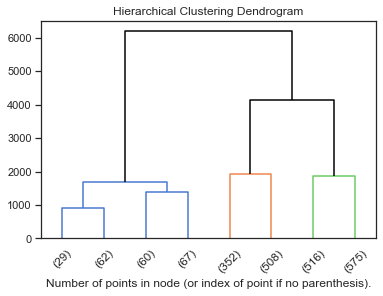

In [254]:
plt.title('Hierarchical Clustering Dendrogram')
# plot the top three levels of the dendrogram
d = plot_dendrogram(HC, truncate_mode='level', p=2 ,leaf_rotation=45, labels=y, count_sort=True,
                color_threshold=3000, above_threshold_color='black', cmap=cmap_point)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

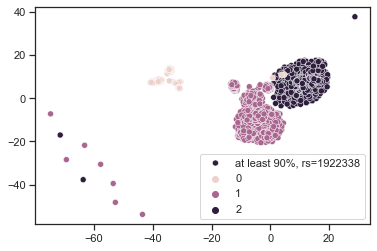

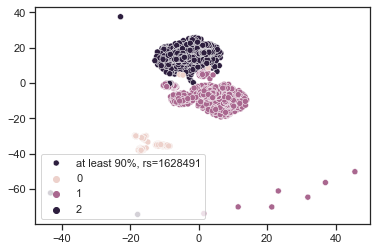

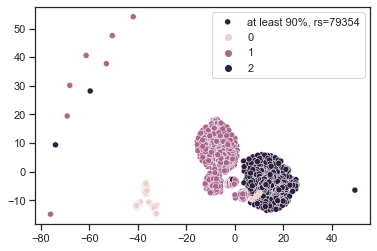

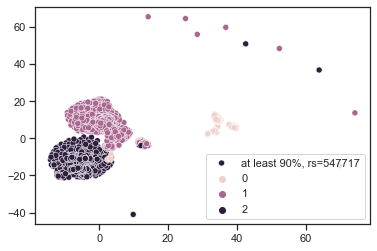

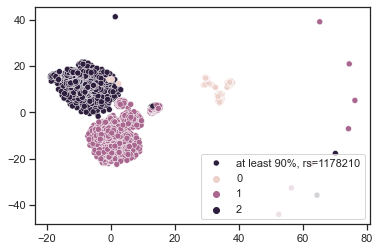

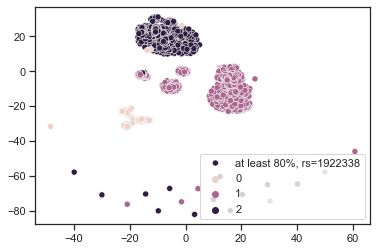

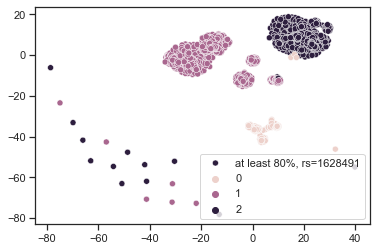

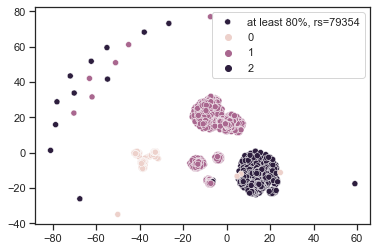

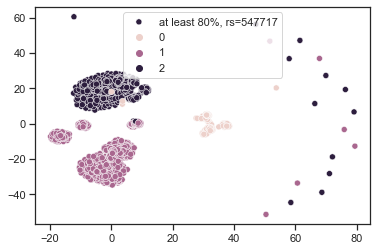

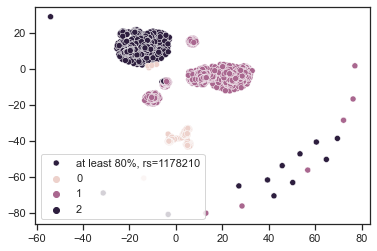

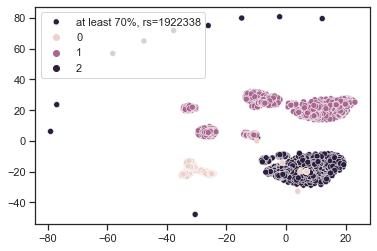

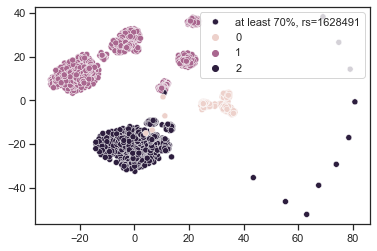

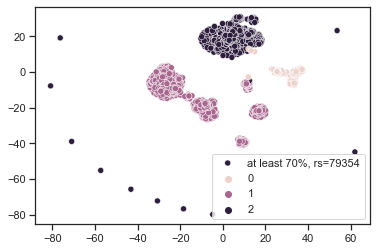

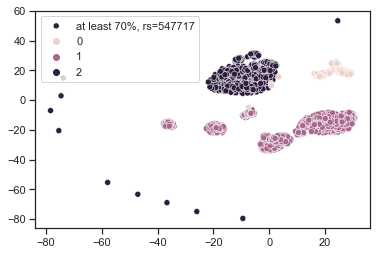

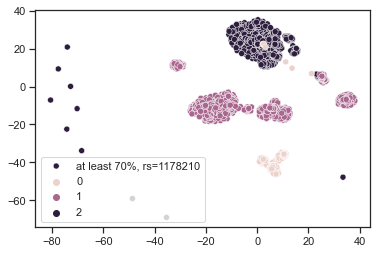

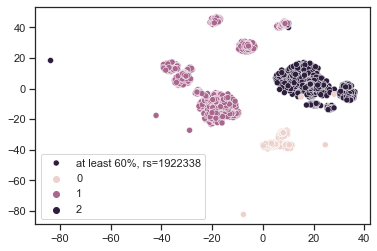

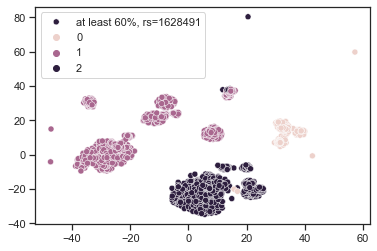

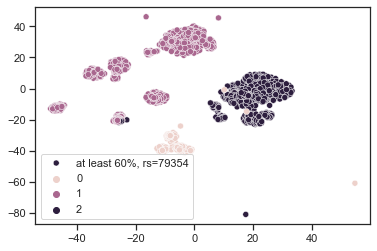

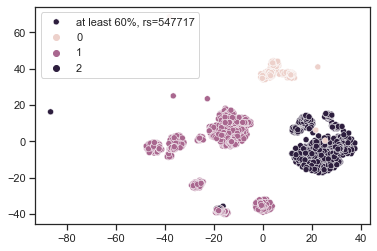

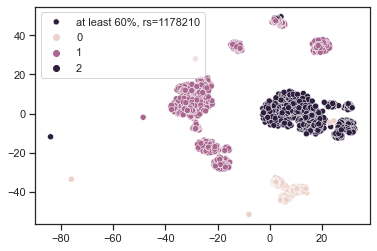

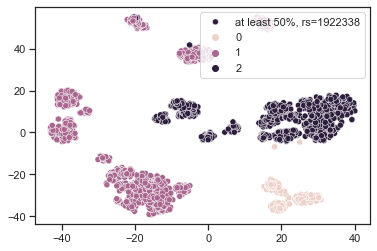

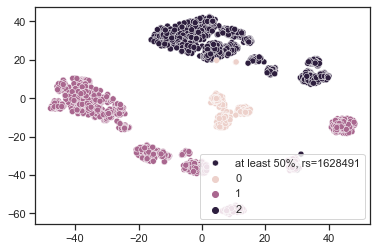

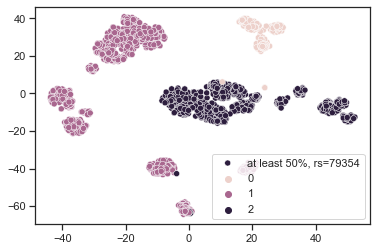

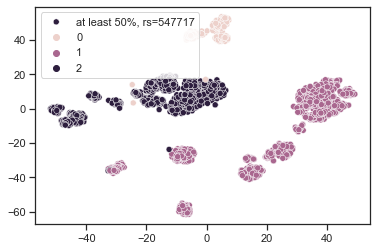

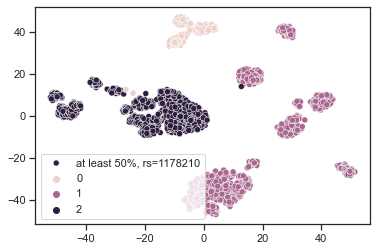

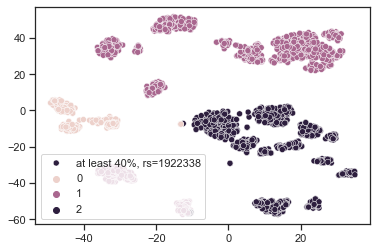

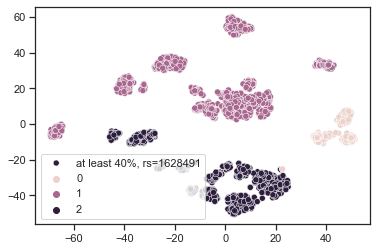

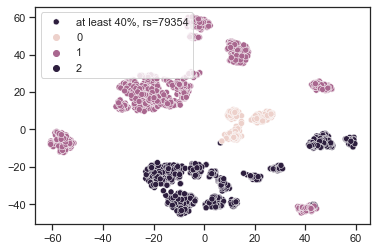

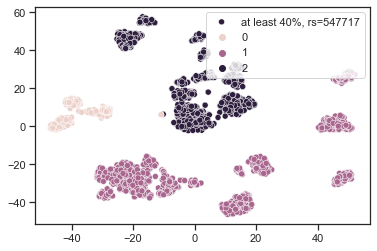

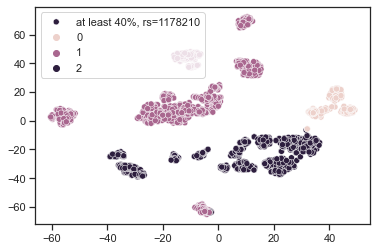

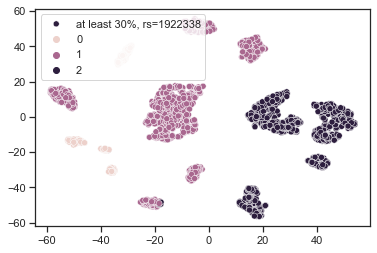

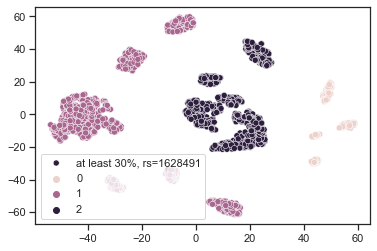

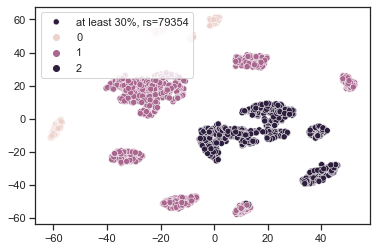

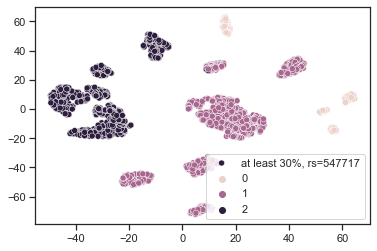

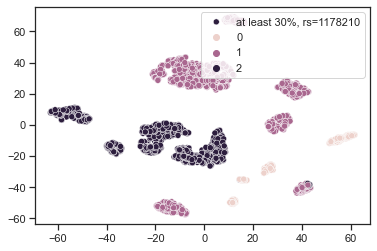

In [48]:
k = 3
for i in range(len(alps)):
    for rs in randomseeds:
        tsne = TSNE(n_components=2,
                    perplexity=40,
                    random_state=rs)
        X_tsne = tsne.fit_transform(X_pca_list[i])
        sns.scatterplot(x=X_tsne[:,0], y=X_tsne[:,1], hue=kmeans_label, label=f'at least {90-i*10}%, rs={rs}')
        plt.show()

In [95]:
from mlxtend.plotting import plot_decision_regions

ModuleNotFoundError: No module named 'mlxtend'

In [174]:
cmap_point = sns.color_palette('muted', as_cmap=True)

In [175]:
cmap_point

['#4878D0',
 '#EE854A',
 '#6ACC64',
 '#D65F5F',
 '#956CB4',
 '#8C613C',
 '#DC7EC0',
 '#797979',
 '#D5BB67',
 '#82C6E2']